# CSC 84040 - Project 1 - Itemset Mining

## Project Description
In this project you will perform itemset mining on a dataset comprised of anonymized Instacart orders placed in 2017.

### Data
There are two data files associated with this project, both available via Blackboard:
- *project1_data.csv*
- *frequent_2_itemsets.csv*

### Software Packages
The following Python software packages are required to complete the project:
- `pandas`
- `numpy`
- `scikit-learn`
- `matplotlib`
- `mlxtend`

## Part 0: Load, Transform, and Explore the Dataset

Set the variable `DATA_FILE` to the **full path** to the project's dataset (**project1_data.csv**) on your system. The dataset is a CSV file where each line contains an **order** (indexed by `order_id`) and a **product** that was purchased as part of their order (`product_id`). 
1. Read in the dataset and create *itemsets* by linking each unique `order_id` with the set of associated `product_id`s.
2. Using the newly created itemsets, you will create *two different data structures* for use in subsequent analyses:
   1. **Itemset matrix** - Create a matrix, e.g., a 2-D `numpy` array, where each *row* represents an *itemset* and each *column* represents an *item*. Within this matrix, each cell encodes whether an item is in an itemset or not. The `Scikit-learn` function `MultiLabelBinarizer`[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html) will be useful for this task.
   2. **Itemset dataframe** - Create a `pandas DataFrame` from the above itemset matrix whose column names corresponding to the product names.
3. Let's *investigate* the dataset a bit before proceeding with itemset analysis:
   1. How many **unique orders** are there in the dataset? **Unique products**?
   2. Produce a **histogram** of order sizes, i.e., the number of products per order. How are the order sizes distributed?
   3. What are the **top fifty (50) products** ordered across all orders in the dataset?

In [1]:
import pandas as pd
import numpy as np

##### 1.

In [2]:
DATA_FILE = pd.read_csv('project1_data.csv')
itemsets = DATA_FILE.groupby("order_id")["product_id"].apply(set)

##### 2.

In [3]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
itemset_matrix = mlb.fit_transform(itemsets)
itemset_items = mlb.classes

In [4]:
items = mlb.classes_
itemset_df = pd.DataFrame(itemset_matrix, columns=items)

##### 3.

In [5]:
itemset_df.shape

(32149, 25477)

There are 32149 unique orders and 25477 unique products

###### B.

<IPython.core.display.Javascript object>


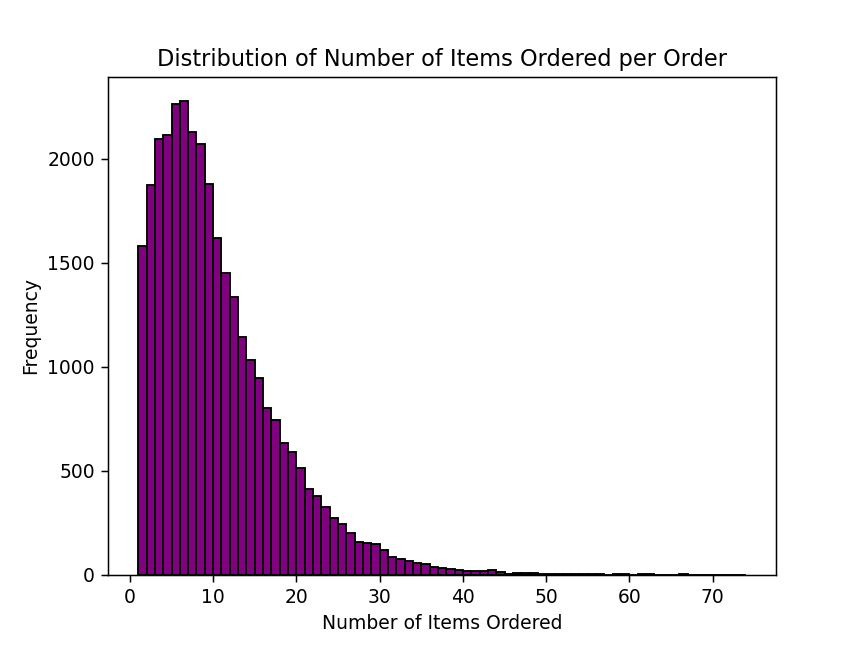

In [18]:
import matplotlib.pyplot as plt
%matplotlib notebook

total_ordered = []

for i in range(len(itemset_df)):
    item_count = itemset_df.iloc[i].sum()
    total_ordered.append(item_count)

plt.hist(total_ordered, bins = range(min(total_ordered), max(total_ordered)+2), color = 'purple', edgecolor='black')
plt.xlabel('Number of Items Ordered')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Items Ordered per Order')
plt.show()

Distribution is right skewed

##### C.

In [7]:
item_rank = itemset_df.sum()
temp = item_rank.sort_values(ascending = False)
temp.head(50)

Banana                                  4818
Bag of Organic Bananas                  3797
Organic Strawberries                    2715
Organic Baby Spinach                    2530
Organic Hass Avocado                    2136
Organic Avocado                         1794
Large Lemon                             1522
Limes                                   1431
Strawberries                            1411
Organic Raspberries                     1345
Organic Whole Milk                      1344
Organic Yellow Onion                    1213
Organic Garlic                          1110
Organic Zucchini                        1057
Organic Blueberries                      976
Cucumber Kirby                           967
Organic Fuji Apple                       922
Organic Grape Tomatoes                   855
Organic Lemon                            854
Organic Cucumber                         829
Apple Honeycrisp Organic                 810
Organic Baby Carrots                     808
Honeycrisp

## Part 1.1: The Apriori Algorithm

You will now apply the *Apriori algorithm* to the Instacart dataset by utilizing the `Mlxtend` function `apriori`[documentation](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/#api).
1. Create a wrapper function `instacart_frequent_itemsets` that utilizes the `apriori` function to find all frequent $k$-itemsets with a minimal support of `min_support` in the Instacart dataset.  The function should be passed the **itemset dataframe** along with parameters `k` and `min_support`.
   Your function should return a `pandas DataFrame` with two columns:
   -	The first one is named `support` and stores the support of the frequent itemsets.
   -    The second column is named `itemsets` and stores the frequent itemset as a frozenset (the default return type of the `apriori` function).
   Your function should pass the parameter `use_colnames=True` to the `apriori` function, which will come in handy later on in the project. Ensure that you are *only* returning the frequent itemsets that have the specified number of products ($k$).

2. Using `instacart_frequent_itemsets` function, find all frequent $3$-itemsets with a minimum support of **0.004**.


In [8]:
#pip install mlxtend==0.17.1

##### 1.

In [5]:
from mlxtend.frequent_patterns import apriori

In [6]:
def instacart_frequent_itemsets(itemset, k, min_support):
    frequent = apriori(itemset, min_support=min_support, use_colnames=True, max_len=k, low_memory = True)
    filtered_itemsets = frequent[frequent['itemsets'].apply(lambda x: len(x)) >= k]
    return filtered_itemsets

##### 2.

In [7]:
frequent_sets = instacart_frequent_itemsets(itemset_df,3,0.004)

In [8]:
frequent_sets

,support,itemsets
489,0.004106,"(Organic Baby Spinach, Bag of Organic Bananas,..."
490,0.004293,"(Organic Strawberries, Organic Baby Spinach, B..."
491,0.004604,"(Organic Strawberries, Bag of Organic Bananas,..."


## Part 1.2: Manual Implementation of the Apriori Algorithm

In this part of the assignment, we are going to continue our exploration in mining frequent itemsets. Specifically, we are going to examine a few key steps in the Apriori algorithm.

### 1.2.1 Candidate Generation

A critical step of the Apriori algorithm is *candidate generation*. That is, candidate $(k+1)$-itemsets should be generated from *frequent* $k$-itemsets. Your task in this section is to generate candidate $3$-itemsets based on the frequent $2$-itemsets.
 
1. Create a `generate_candidate_3_itemsets` function, which takes as *input* a list of frequent $2$-itemsets and *returns* a list of the candidate $3$-itemsets (*candidate* means that they may or may not be frequent). Each itemset should be stored as a `set` in Python. Ensure that for each candidate $3$-itemset in your returned list, at least one of its size-$2$ subsets is a frequent $2$-itemset, and that the list does not contain duplicate itemsets.
   You will utilize the frequent $2$-itemsets prepared for you and stored in the the file **frequent_2_itemsets.csv**. Set the variable `FI2_FILE` to the **full path** to this file. We will evaluate your function by feeding in the loaded 2-itemsets and examining the return value.

   You will receive full points for Part 1.2.1 if (1) every candidate $3$-itemset in your returned list is a *superset* of at least one frequent 2-itemset, (2) every 3-itemset that has a frequent size-2 subset is already in your list, and (3) your list does not contain duplicated sets.

2. Note that above procedure will not produce a minimal set of candidate $3$-itemsets. **Prune** the candidate itemsets produced above by requiring all size-$2$ subsets of each candidate 3-itemset to be frequent. You will receive full points for this part if the pruning is done correctly.

##### 1.

In [9]:
FI2_FILE = pd.read_csv('frequent_2_itemsets.csv',header=None)
FI2_FILE.head()

,0,1
0,Banana,100% Whole Wheat Bread
1,Bag of Organic Bananas,Apple Honeycrisp Organic
2,Apple Honeycrisp Organic,Banana
3,Apple Honeycrisp Organic,Organic Baby Spinach
4,Apple Honeycrisp Organic,Organic Hass Avocado


In [10]:
def generate_candidate_3_itemsets(item_2):
    candidates = []
    unique_items = set(item_2[0].unique()).union(item_2[1].unique()) #set of all unique items 
    
    for row in range(len(item_2)):  
        subset = set(item_2.iloc[row][:2])  # Access row using iloc to get the subset
        for item in unique_items:
            if item not in subset:
                superset = subset.copy()
                superset.add(item)
                if superset not in candidates:
                    candidates.append(superset)
    
    return candidates

candidates = generate_candidate_3_itemsets(FI2_FILE)
#print(candidates)

##### 2.

In [11]:
def prune(item_2, candidates):
    item_2sets = []
    for row in range(len(item_2)):
        set2 = set(item_2.iloc[row][:2])
        item_2sets.append(set2)
    pruned_candidates = []
    for superset in candidates:
        superset_list = list(superset)
        subset = []
        subset.append({superset_list[0], superset_list[1]})  
        subset.append({superset_list[0], superset_list[2]})  
        subset.append({superset_list[1], superset_list[2]}) 
        # Check if all size-2 subsets are frequent
        if all(sub in item_2sets for sub in subset):
            pruned_candidates.append(superset)
    return pruned_candidates

pruned_sets = prune(FI2_FILE, candidates)
print(pruned_sets)

[{'Organic Baby Spinach', 'Apple Honeycrisp Organic', 'Bag of Organic Bananas'}, {'Apple Honeycrisp Organic', 'Bag of Organic Bananas', 'Organic Hass Avocado'}, {'Organic Strawberries', 'Apple Honeycrisp Organic', 'Bag of Organic Bananas'}, {'Organic Baby Spinach', 'Apple Honeycrisp Organic', 'Banana'}, {'Apple Honeycrisp Organic', 'Banana', 'Organic Hass Avocado'}, {'Organic Strawberries', 'Apple Honeycrisp Organic', 'Banana'}, {'Organic Baby Spinach', 'Apple Honeycrisp Organic', 'Organic Hass Avocado'}, {'Organic Baby Spinach', 'Organic Strawberries', 'Apple Honeycrisp Organic'}, {'Organic Strawberries', 'Apple Honeycrisp Organic', 'Organic Hass Avocado'}, {'Large Lemon', 'Limes', 'Bag of Organic Bananas'}, {'Large Lemon', 'Organic Garlic', 'Bag of Organic Bananas'}, {'Large Lemon', 'Organic Baby Spinach', 'Bag of Organic Bananas'}, {'Large Lemon', 'Bag of Organic Bananas', 'Organic Hass Avocado'}, {'Large Lemon', 'Organic Avocado', 'Bag of Organic Bananas'}, {'Large Lemon', 'Organic

### 1.2.2 Frequent Itemset Filtering

With the candidate itemsets ready, the next step  iteration of the Apriori algorithm is to determine the frequent items. This can be achieved by using the **itemset matrix** to
- *count the occurrence* of each candidate itemset,
- divide it by the *total number of records* to derive the **support**, and
- *output candidate itemsets* whose **support meets a chosen threshold**.
 
1. Create a new function `calculate_frequent_itemsets`, which takes as *input* `candidate_itemsets`, the list of the candidate $3$-itemsets from the previous section, along with the parameter `min_support`. Your function should return the complete list of frequent 3-itemsets with support $\ge$
`min_support`. The returned list should not contain duplicated itemsets. The order of the list does not matter.

2. How *many* 3-frequent itemsets were found when `calculate_frequent_itemsets` is called with `min_support=.004`? If any itemsets are returned, *what are the products* contained in them? You may use the `inverse_transform` method of the fitted `MultiLabelBinarizer` transformer to recover the product names from the itemset's binary representation.

##### 1.

In [12]:
def calculate_frequent_itemsets(candidate_itemsets, min_support,total_orders):
    threshold_met = []
    for itemset in candidate_itemsets:
        # count occurance of itemset in the matrix
        occurance = 0
        for order in total_orders:
            if all(item in order for item in itemset):
                occurance += 1
        # see if support meets the minimum support
        if occurance/len(total_orders) >= min_support:
            threshold_met.append(itemset)
    return threshold_met

##### 2.

In [13]:
mlb2 = MultiLabelBinarizer() 
pruned_set = mlb2.fit_transform(pruned_sets) #transform the pruned sets
frequent_items = calculate_frequent_itemsets(pruned_set, 0.004, itemset_matrix)
#run time 40-50min

In [14]:
frequent_items_array = np.array(frequent_items) #transform filtered set to set of arrays
labeled_sets = mlb2.inverse_transform(frequent_items_array) #recieve labels from filtered pruned sets
print(len(labeled_sets))  #get count of 3-itemsets
flattened_list = [item for sublist in labeled_sets for item in sublist] #list of items of all 3 itemset

# Get the unique items in 3-itemsets
unique_elements = set(flattened_list)

print(unique_elements)

187
{'Organic Raspberries', 'Organic Cucumber', 'Cucumber Kirby', 'Organic Whole Milk', 'Organic Blackberries', 'Organic Cilantro', 'Strawberries', 'Bag of Organic Bananas', 'Organic Tomato Cluster', 'Organic Baby Carrots', 'Limes', 'Original Hummus', 'Organic Garlic', 'Organic Baby Spinach', 'Organic Gala Apples', 'Organic Hass Avocado', 'Organic Zucchini', 'Organic Avocado', 'Organic Yellow Onion', 'Apple Honeycrisp Organic', 'Organic Blueberries', 'Organic Small Bunch Celery', 'Organic Lemon', 'Organic Grape Tomatoes', 'Organic Baby Arugula', 'Organic Strawberries', 'Banana', 'Organic Large Extra Fancy Fuji Apple', 'Large Lemon'}


187 3-itemsets

## Part 2: Evaluating Frequent Itemsets

Even though you may have found all the frequent itemsets, not all of them are “interesting”.

Various method to quantify the *interestingness* of patterns have been developed. Most of them split the itemset into an **antecedent item(set)** and a **consequent item(set)**, and then measure the correlation between the antecedent and the consequent. You can readily compute a number of these measures using the `MLxtend` package.

1. First, apply your `instacart_frequent_itemsets` function to the **itemset dataframe** with a `min_support` of $0.003$. Then, apply the `association_rules` function from `MLxtend` [documentation](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/) with the parameter value `min_threshold=.01` **N.B.** The current version of the `association_rules` function does not appear to implement the  `min_threshold` parameter correctly when the  `metric` parameter is specified.

2. One of the interestingness measures calculated by the `association_rules` function is **lift**. Which rules have a lift $\ge 6$? For these items how do the other interestingness measures compare? What conclusions can you draw (if any) from these results?

3. You will now implement a different interestingness measurement, the *full* **mutual information (MI)** (as opposed *pointwise* MI, which is sometimes used in clustering). MI is defined as:
   $$
    I(X;Y)= \sum_{x\in\mathcal{X}}\sum_{y\in\mathcal{Y}}P(X=x,Y=y)\log_2\dfrac{P(X=x,Y=y)}{P(X=x)P(Y=y)}
    $$

   The samples spaces $\mathcal{X},\mathcal{Y}$ in this context are same and correspond to the products found in the dataset. The random variables $X$ and $Y$ are binary-valued and indicate the presence (1) or absence (0) of a product in an itemset. Thus, there are four possible values - $(X=0,Y=0),(X=0,Y=1),(X=1,Y=0),$ and $(X=1,Y=1)$ - that must be considered in computing MI.

   Construct a function `mi` that uses the three support values computed in step 2. i.e., (1) **antecedent support**, (2) **consequent support**, and (3) **support**, to compute the mutual information. All three of these values as computed by the `association_rules` function are in the interval $[0, 1]$ and you may assume the validity of the input. Ensure that you use log base $2$.

4. Create a function `mi_df` that adds a column `mi` to the `association_rules` `DataFrame` with each row's corresponding to the mutual information value as computed by your `mi` function.

##### 1.

In [15]:
freq_itemsetsdf = instacart_frequent_itemsets(itemset_df,k=3,min_support=0.003)

In [16]:
freq_itemsetsdf

,support,itemsets
790,0.004106,"(Organic Baby Spinach, Bag of Organic Bananas,..."
791,0.004293,"(Organic Strawberries, Organic Baby Spinach, B..."
792,0.003546,"(Organic Raspberries, Bag of Organic Bananas, ..."
793,0.004604,"(Organic Strawberries, Bag of Organic Bananas,..."
794,0.003888,"(Organic Raspberries, Organic Strawberries, Ba..."
795,0.003857,"(Organic Avocado, Organic Baby Spinach, Banana)"
796,0.003017,"(Organic Strawberries, Organic Baby Spinach, B..."


In [22]:
from mlxtend.frequent_patterns import association_rules

freq_itemsetsdf2 =  apriori(itemset_df, min_support=0.003, use_colnames=True, max_len=3, low_memory = True) #function won't work directly with function
rules = association_rules(freq_itemsetsdf2, metric = "confidence", min_threshold = 0.01)
rules = rules[(rules['antecedents'].apply(len) >= 2) | (rules['consequents'].apply(len) >= 2)] #filter to a itemset with possible length of 3
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
548,"(Bag of Organic Bananas, Organic Hass Avocado)",(Organic Baby Spinach),0.019441,0.078696,0.004106,0.211200,2.683743,0.002576,1.167982
549,"(Bag of Organic Bananas, Organic Baby Spinach)",(Organic Hass Avocado),0.018072,0.066441,0.004106,0.227194,3.419511,0.002905,1.208013
550,"(Organic Hass Avocado, Organic Baby Spinach)",(Bag of Organic Bananas),0.011478,0.118106,0.004106,0.357724,3.028827,0.002750,1.373075
551,(Bag of Organic Bananas),"(Organic Hass Avocado, Organic Baby Spinach)",0.118106,0.011478,0.004106,0.034764,3.028827,0.002750,1.024125
552,(Organic Hass Avocado),"(Bag of Organic Bananas, Organic Baby Spinach)",0.066441,0.018072,0.004106,0.061798,3.419511,0.002905,1.046606
553,(Organic Baby Spinach),"(Bag of Organic Bananas, Organic Hass Avocado)",0.078696,0.019441,0.004106,0.052174,2.683743,0.002576,1.034535
554,"(Bag of Organic Bananas, Organic Strawberries)",(Organic Baby Spinach),0.020281,0.078696,0.004293,0.211656,2.689543,0.002697,1.168658
555,"(Bag of Organic Bananas, Organic Baby Spinach)",(Organic Strawberries),0.018072,0.084451,0.004293,0.237522,2.812552,0.002766,1.200755
556,"(Organic Strawberries, Organic Baby Spinach)",(Bag of Organic Bananas),0.012784,0.118106,0.004293,0.335766,2.842917,0.002783,1.327686
557,(Bag of Organic Bananas),"(Organic Strawberries, Organic Baby Spinach)",0.118106,0.012784,0.004293,0.036344,2.842917,0.002783,1.024449


##### 2.

In [23]:
rules = association_rules(freq_itemsetsdf2, metric = "lift", min_threshold = 6) #no itemset of 3 exist in the original dataframe
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Limes),(Bunched Cilantro),0.044511,0.014619,0.004013,0.090147,6.166230,0.003362,1.083010
1,(Bunched Cilantro),(Limes),0.014619,0.044511,0.004013,0.274468,6.166230,0.003362,1.316949
2,(Limes),(Jalapeno Peppers),0.044511,0.013126,0.003764,0.084556,6.441704,0.003179,1.078028
3,(Jalapeno Peppers),(Limes),0.013126,0.044511,0.003764,0.286730,6.441704,0.003179,1.339589
4,(Lime Sparkling Water),(Sparkling Water Grapefruit),0.015335,0.022800,0.004230,0.275862,12.099167,0.003881,1.349467
5,(Sparkling Water Grapefruit),(Lime Sparkling Water),0.022800,0.015335,0.004230,0.185539,12.099167,0.003881,1.208977
6,(Limes),(Organic Cilantro),0.044511,0.020654,0.005817,0.130678,6.327051,0.004897,1.126563
7,(Organic Cilantro),(Limes),0.020654,0.044511,0.005817,0.281627,6.327051,0.004897,1.330072
8,(Sparkling Lemon Water),(Sparkling Water Grapefruit),0.010140,0.022800,0.003017,0.297546,13.050214,0.002786,1.391123
9,(Sparkling Water Grapefruit),(Sparkling Lemon Water),0.022800,0.010140,0.003017,0.132333,13.050214,0.002786,1.140829


The items with a higher lift of above 6 contain support of (0.3,0.6) and confidence of (0.1,0.3). Itemsets containing limes tend to have confidence level close to 6 while sparkling flavored water drinks tend to have higher lift count. Different flavored sparkling water are likely to be in a itemset based on the high lift count. Lime also has a higher confidence which can mean that an itemset will probably contain a lime (consequent)

##### 3.

In [24]:
import math

def mi(antecedent, consequent, support):
    # support - probability both X or Y
    # antecedent - probability X
    # consequent - probability Y
    x = antecedent
    xnot = 1 - antecedent
    y = consequent
    ynot = 1 - y
    both = support
    xnot_y = y - both
    ynot_x = x - both
    not_both = ynot - ynot_x
    MI = (both*math.log2(both/(x*y))) + (ynot_x*math.log2(ynot_x/(x*ynot))) + (xnot_y*math.log2(xnot_y/(xnot*y))) + (not_both*math.log2(not_both/(ynot*xnot)))
    return MI

##### 4.

In [25]:
def mi_df(rules):
    mi_values = []
    #find MI in each row
    for index, row in rules.iterrows():
        antecedent = row["antecedent support"]
        consequent = row["consequent support"]
        support = row["support"]
        mi_values.append(mi(antecedent, consequent, support))  
    rules['mi'] = mi_values
    return rules

In [26]:
mi_df(rules)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,mi
0,(Limes),(Bunched Cilantro),0.044511,0.014619,0.004013,0.090147,6.166230,0.003362,1.083010,0.006517
1,(Bunched Cilantro),(Limes),0.014619,0.044511,0.004013,0.274468,6.166230,0.003362,1.316949,0.006517
2,(Limes),(Jalapeno Peppers),0.044511,0.013126,0.003764,0.084556,6.441704,0.003179,1.078028,0.006344
3,(Jalapeno Peppers),(Limes),0.013126,0.044511,0.003764,0.286730,6.441704,0.003179,1.339589,0.006344
4,(Lime Sparkling Water),(Sparkling Water Grapefruit),0.015335,0.022800,0.004230,0.275862,12.099167,0.003881,1.349467,0.010940
5,(Sparkling Water Grapefruit),(Lime Sparkling Water),0.022800,0.015335,0.004230,0.185539,12.099167,0.003881,1.208977,0.010940
6,(Limes),(Organic Cilantro),0.044511,0.020654,0.005817,0.130678,6.327051,0.004897,1.126563,0.009807
7,(Organic Cilantro),(Limes),0.020654,0.044511,0.005817,0.281627,6.327051,0.004897,1.330072,0.009807
8,(Sparkling Lemon Water),(Sparkling Water Grapefruit),0.010140,0.022800,0.003017,0.297546,13.050214,0.002786,1.391123,0.008054
9,(Sparkling Water Grapefruit),(Sparkling Lemon Water),0.022800,0.010140,0.003017,0.132333,13.050214,0.002786,1.140829,0.008054


## Part 3: Itemset Similarity

Recall that *pattern* and *similarity* are two basic **outputs of data mining**. Thus far we have been analyzing **patterns** - *frequent itemsets* and *association* rules. In this last part you will explore itemset **similarities**.

In particular, you will utilize the **Jaccard similarity coefficient (JSC)**, or *Jaccard index*, a simple by useful measure of itemset similarity, defined as:
$$
J(A,B) =\dfrac{A\cap B}{A\cup B}.
$$

1. Construct a function `jaccard_similarity`, to calculate the *Jaccard similarity coefficient* between two sets. You may assume that a) at least one set is non-empty, and b) the sets are provided as binary vectors of equal (but arbitrarily finite) length that indicate element membership.
2. Sample `1000` rows **uniformly at random and without replacement** from the *itemset matrix*. Please first use the `numpy.random.default_rng` function to create a random generator object `rng`, setting the random state to your **CUNY Student ID Number** by passing in the `seed=` parameter, and then calling the `rng.choice` method. 
3. Create a function `js_itemset_matrix` that takes as `input` the **sampled** itemset matrix and computes the *Jaccard similarity coefficient* for all pairs of passed itemsets, returning as output the top $x$ items as specified by the `max_items` parameter. A few tips/tricks: 1) you can utilize *triangular indexing* (see Leskovec et al. pg 222) to reduce space and computational costs; 2) a priority queue can be implemented using Python's `heapq` to store only the top `max_items`.
4. Once you've found the top `max_items`, print out the JSC values and the associated itemsets from highest to lowest order. As before, you may use the `inverse_transform` method of the fitted `MultiLabelBinarizer` transformer to recover the product names from the itemset's binary representation.

##### 1.

In [4]:
import numpy as np

def jaccard_similarity(set1, set2):
    set_intersection = np.sum(np.logical_and(set1, set2))
    set_union = np.sum(np.logical_or(set1, set2))
    jaccard = float(set_intersection) / float(set_union)
    return jaccard

##### 2.

In [5]:
rng = np.random.default_rng(seed=24057647)
itemset_sample = rng.choice(itemset_matrix, size=1000, replace = False)

##### 3.

In [9]:
def js_itemset_matrix(sample, max_items):
    top_items = []
    
    # Loop through itemsets in a triangular fashion
    for i in range(len(sample)):
        for j in range(i+1, len(sample)):
            jac = jaccard_similarity(sample[i], sample[j])
            
            if len(top_items) < max_items:
                top_items.append([jac, sample[i], sample[j]])
            elif jac > top_items[0][0]:
                top_items[0] = [jac, sample[i], sample[j]]
            top_items.sort(key=lambda x: x[0])
    return top_items

##### 4.

In [10]:
# Calculate Jaccard similarity coefficients and sort them

jaccard_sets = js_itemset_matrix(itemset_sample, 3)
sorted_jaccard = sorted(jaccard_sets, key=lambda x: x[0])


#sample 1000

In [11]:
# Iterate over sorted Jaccard similarities and print corresponding itemsets
for sets in sorted_jaccard:
    set1 = np.array([sets[1]])
    set2 = np.array([sets[2]])
    transformed1 = mlb.inverse_transform(set1)
    transformed2 = mlb.inverse_transform(set2)
    print("JSC", sets[0], "Itemset1:", transformed1, "Itemset2:", transformed2)

JSC 0.5 Itemset1: [('Baby Cucumbers', 'Green Seedless Grapes')] Itemset2: [('Baby Cucumbers',)]
JSC 0.6666666666666666 Itemset1: [('Creamy Almond Butter', 'Organic Simply Naked Pita Chips', 'Soda')] Itemset2: [('Organic Simply Naked Pita Chips', 'Soda')]
JSC 1.0 Itemset1: [('Whole Grain Cheddar Baked Snack Crackers',)] Itemset2: [('Whole Grain Cheddar Baked Snack Crackers',)]
